In [2]:
# # Import Libraries
# import matplotlib
# matplotlib.use('agg')
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
# %load_ext line_profiler

import numpy as np
import pickle
import pandas as pd
import sys
import time, random               # add some random sleep time
import scipy
import glob
import scipy.stats as stats
import time
import os
import math
import copy
import statsmodels.api as sm
import itertools
import re
import itertools
import shutil
import h5py
import matplotlib
from scipy.io import arff

from os import listdir

# from spot import SPOT
from os.path import isfile, join
# from statsutils import *
from boltons.statsutils import *
from datetime import datetime
from itertools import repeat,cycle, islice
from ipywidgets import interact
from dateutil.parser import parse

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import check_random_state, shuffle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.svm import OneClassSVM as ocsvm
from sklearn import cluster, datasets, metrics, mixture,svm
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor,kneighbors_graph
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


from scipy import linalg
from scipy.special import gamma, factorial, digamma,betaln, gammaln
from scipy.stats import beta, multivariate_normal, wishart,invwishart,t, mode
from scipy.stats import genextreme as gev
import scipy.spatial as sp
import scipy.io
from scipy.io import arff

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pylab as pylab
import matplotlib as mpl

sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline

# Global Figure Parameters
import matplotlib.pylab as pylab
global label_size
global fig_len
global fig_wid
global m_size
global title_size

fig_len=16
fig_wid=16
m_size=50
title_size=50
label_size=30

plot_params = {'legend.fontsize': 60,
          'figure.figsize': (fig_len, fig_wid),
         'axes.labelsize': label_size,
         'axes.titlesize':title_size,
         'xtick.labelsize':label_size,
         'ytick.labelsize':label_size}
pylab.rcParams.update(plot_params)





In [3]:
os.chdir("..")

In [42]:
from lib.core import *
import glob
from tqdm import tqdm

In [31]:
def cleaned_covid_df(data_path):
    data_source_covid = data_path
    all_filenames = [i for i in glob.glob(data_source_covid+'/'+'*.{}'.format('csv'))]
    data_deaths = pd.concat([pd.read_csv(f) for f in all_filenames if '_US' in f and 'death' in f])
    data_confirmed = pd.concat([pd.read_csv(f) for f in all_filenames if '_US' in f and 'confirmed' in f])


    data_deaths0=data_deaths.groupby(['FIPS', 'Admin2', 'Province_State','Country_Region']).sum().reset_index()
    data_deaths1=data_deaths0[data_deaths0['Population']>50000]
    data_deaths2=data_deaths1.drop(['UID',  'code3', 'FIPS', 'Admin2', 'Province_State','Country_Region', 'Lat', 'Long_'],axis=1)
    data_deaths3=data_deaths2.div(data_deaths2['Population'],axis=0)
    data_deaths3=data_deaths3.drop(['Population'],axis=1)


    data_confirmed_0=data_confirmed.join(data_deaths[['FIPS','Province_State','Admin2','UID','Population']].set_index(['FIPS','Province_State','Admin2','UID']), on=['FIPS','Province_State','Admin2','UID'])
    data_confirmed0=data_confirmed_0.groupby(['FIPS', 'Admin2', 'Province_State','Country_Region']).sum().reset_index()
    data_confirmed1=data_confirmed0[data_confirmed0['Population']>50000]
    data_confirmed2=data_confirmed1.drop(['UID',  'code3', 'FIPS', 'Admin2', 'Province_State','Country_Region', 'Lat', 'Long_'],axis=1)
    data_confirmed3=data_confirmed2.div(data_confirmed2['Population'],axis=0)
    data_confirmed3=data_confirmed3.drop(['Population'],axis=1)


    data_deaths_full0=data_deaths.groupby(['FIPS', 'Admin2', 'Province_State','Country_Region']).sum().reset_index()
    data_deaths_full1=data_deaths_full0[data_deaths_full0['Population']>50000]
    data_deaths_full2=data_deaths_full1.drop(['UID',  'code3', 'FIPS', 'Admin2', 'Province_State','Country_Region', 'Lat', 'Long_'],axis=1)
    data_deaths_full3=data_deaths_full2#.div(data_deaths_full2['Population'],axis=0)
    data_deaths_full3=data_deaths_full3.drop(['Population'],axis=1)

    data_confirmed_full_0=data_confirmed.join(data_deaths[['FIPS','Province_State','Admin2','UID','Population']].set_index(['FIPS','Province_State','Admin2','UID']), on=['FIPS','Province_State','Admin2','UID'])
    data_confirmed_full0=data_confirmed_full_0.groupby(['FIPS', 'Admin2', 'Province_State','Country_Region']).sum().reset_index()
    data_confirmed_full1=data_confirmed_full0[data_confirmed_full0['Population']>50000]
    data_confirmed_full2=data_confirmed_full1.drop(['UID',  'code3', 'FIPS', 'Admin2', 'Province_State','Country_Region', 'Lat', 'Long_'],axis=1)
    data_confirmed_full3=data_confirmed_full2#.div(data_confirmed_full2['Population'],axis=0)
    data_confirmed_full3=data_confirmed_full3.drop(['Population'],axis=1)


    data_deaths5=[]
    N_counties,T =data_deaths3.shape
    for i in range(N_counties):
        dd=np.array(data_deaths3.iloc[i])
        c_start=np.where(dd>0)[0]
        if len(c_start)>0:
            dd=np.append(dd[c_start[0]:], np.ones(c_start[0])*np.nan)
        else:
            dd=np.ones(T)*np.nan
        data_deaths5.append(dd)
    data_deaths5=pd.DataFrame(np.array(data_deaths5))
    data_deaths5=data_deaths5.set_index(data_deaths3.index)


    data_confirmed5=[]
    N_counties,T =data_confirmed3.shape
    for i in range(N_counties):
        dd=np.array(data_confirmed3.iloc[i])
        c_start=np.where(dd>0)[0]
        if len(c_start)>0:
            dd=np.append(dd[c_start[0]:], np.ones(c_start[0])*np.nan)
        else:
            dd=np.ones(T)*np.nan
        data_confirmed5.append(dd)
    data_confirmed5=pd.DataFrame(np.array(data_confirmed5))
    data_confirmed5=data_confirmed5.set_index(data_confirmed3.index)

    return data_deaths5, data_confirmed5, pd.DatetimeIndex(data_deaths3.columns)
def load_data(file_path):
    filename, extension = os.path.splitext(file_path)
    name=(os.path.basename(file_path))
    if (extension=='.mat'):
        try:
            mat = scipy.io.loadmat(file_path)
            df = pd.DataFrame(np.hstack((mat['X'], mat['y'])))
            X,y=mat['X'], mat['y']
            return df,X,y

        except:
            try:
                arrays = {}
                f = h5py.File(file_path)
                for k, v in f.items():
                    arrays[k] = np.array(v)
                X,y=arrays['X'].T,arrays['y'].T
                df = pd.DataFrame(np.hstack((arrays['X'].T, arrays['y'].T)))
                return df,X,y
            except:
                print("1 Failed to load", name)

    elif extension=='.csv':
        try:
            df = pd.read_csv(file_path,low_memory=False,delimiter=',',header=None)
            df1=df[df.columns[(df.dtypes=='float')+(df.dtypes=='int')]]
            if df1.shape[1]==0:
                df = pd.read_csv(file_path,low_memory=False,delimiter=',')
                df1=df[df.columns[(df.dtypes=='float')+(df.dtypes=='int')]]                
            X=np.array(df1).astype(float)
            y=df.drop(df.columns[(df.dtypes=='float')+(df.dtypes=='int')],axis=1)
            return df,X,y
        except:
            try:
                df = pd.read_csv(file_path,low_memory=False,delimiter=',')
                df1=df[df.columns[(df.dtypes=='float')+(df.dtypes=='int')]]
                X=np.array(df1).astype(float)
                y=df.drop(df.columns[(df.dtypes=='float')+(df.dtypes=='int')],axis=1)
                return df,X,y
            except:
                print("2 Failed to load", name)

    elif extension=='.pickle':
        try:
            data=pickle.load(open(file_path,'rb'))
            X=data['X']
            y=data['y']
            return data,X,y
        except:
            try:
                d = pickle.load( open(file_path, "rb" ) )
                data=d['rawdata']
                labels=d['labels']
                X=np.array(data).astype(float)
                y=labels
                df=np.hstack((X,y))
                return df,X,y
            except:
                print("3 Failed to load", name)
                
    elif extension=='.arff':
        data = arff.loadarff(file_path)
        df = pd.DataFrame(data[0])
        df1=df[df.columns[(df.dtypes=='float')+(df.dtypes=='int')]]
        X=np.array(df1).astype(float)
        y=df.drop(df.columns[(df.dtypes=='float')+(df.dtypes=='int')],axis=1)
        return df,X,y
        
    else:
        print("Failed to load the extension",extension)
        pass


In [32]:
data_path = '/Users/lekhag/Documents/Testing Theories/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series'
deaths, confirmed, dates = cleaned_covid_df(data_path)

In [263]:
def lad_z_initialization(X, K_f):
    N,D = X.shape
    if K_f>1:
        X_train, _  = train_test_split(np.arange(0,X.shape[0]), train_size=cluster_train)
        kmeans = MiniBatchKMeans(n_clusters=K_f)
        
        if D>20:
            pca = PCA(n_components=20).fit_transform(X)
            kmeans = kmeans.partial_fit(pca[X_train,:])
            return kmeans.predict(pca)+1
        else:
            kmeans = kmeans.partial_fit(X[X_train,:])
            return kmeans.predict(X)+1
    else:
        return np.ones(N)    

def cleaned_windowed_tsdb(X_full, history_time, start_time_step, d):
    if history_time>0 and history_time<start_time_step:
        X=np.copy(X_full[:,d-history_time:d])
    else:
        X=np.copy(X_full[:,:d])
        
    counties_missing=np.where(np.isnan(X).all(axis=1))[0]
    counties_present=np.where(np.isnan(X).all(axis=1)*1==0)[0]

    X=X[counties_present,:]
    X[np.isnan(X)]=0
    X[X==np.inf]=0

    return X, counties_missing, counties_present

def lad_entropy(X, K_f, K, z_1, cluster_log_probs, ana_score, th):
    N_s,D_s=X.shape
    entropy_2 = np.empty((N_s, K, D_s))
    clusters,sizes=np.unique(np.abs(z_1),return_counts=True)
    if len(clusters)<K_f:
        cluster_prob=(np.exp(cluster_log_probs))+sys.float_info.min
        cluster_prob[np.isinf(np.exp(cluster_log_probs))] = sys.float_info.max
        cluster_prob[np.isnan(np.exp(cluster_log_probs))] = sys.float_info.min
        cluster_prob/=np.sum(cluster_prob,axis=1)[:,np.newaxis]
        z_1=np.array([np.argmax(np.random.multinomial(1,cluster_prob[i]))+1 for i in range(N)])
    if len(np.unique(z_1))<K_f:
        K_f=len(np.unique(z_1))

    K=len(clusters)
    thetas=[]
    for k in clusters:
        ind_k_0=z_1==k
        ind_k=np.where(ind_k_0[ana_score<th])[0]
        c = len(ind_k)
        if c<3:
            ind_k=np.abs(z_1)==k
            thetas.append(tuple((np.mean(X[ind_k],axis=0), 
                        np.array([np.cov(X[:,d]) for d in range(D_s)]))))
        else:
            thetas.append(tuple((np.mean(X[ind_k],axis=0), 
                        np.array([np.cov(X[ind_k,d]) for d in range(D_s)]))))

    cc=range(len(thetas))
    means_=np.array([thetas[k][0].T for k in cc])
    covariances=np.array([thetas[k][1] for k in cc])

    ss=[1/(cov) for cov in covariances]
    for k, (mu, prec_chol) in enumerate(zip(means_, ss)):
        prec_chol[np.isnan(prec_chol)]=0
        prec_chol[np.isinf(prec_chol)]=0
        y=(np.square(X-mu)*prec_chol)/2
        entropy_2[:, k, :] = (y)/sizes[k]

    return entropy_2, sizes

def updated_labels(entropy_DGProjection, z_1, sizes, D_s):
    N_s, K_f = entropy_DGProjection.shape
    if K_f>1:
        cluster_log_probs=-(entropy_DGProjection*sizes)
        z_1=np.argmax(cluster_log_probs,axis=1).flatten()+1
    else:
        cluster_log_probs = np.zeros((N_s, K))

    ana_score=-np.max(-((entropy_DGProjection)), axis=1)
    ana_score_0=np.copy(ana_score)
    ana_score=(ana_score-np.min(ana_score))/(np.max(ana_score)-np.min(ana_score))
    
    th=min(0.95,np.mean(ana_score)+2*np.cov(ana_score))

    z_1[ana_score>=th]*=(-1)
    if np.sum(z_1<0)>min(0.25*N_s,D_s):
        z_1[np.argsort(-ana_score)[:int(0.25*N_s)]]=-1*np.abs(z_1[np.argsort(-ana_score)[:int(0.25*N_s)]])
        z_1[np.argsort(-ana_score)[int(0.25*N_s):]]=np.abs(z_1[np.argsort(-ana_score)[int(0.25*N_s):]])
    
    return z_1, ana_score_0, cluster_log_probs

def ldp_ts_non_uniform(X_full,K_f,th_f,start_time_step,history_time,numiter):
    N,D=X_full.shape
    z={}
    thresholds=np.zeros(D)
    ana_score=np.zeros(N)
    ana_prob_array=np.zeros((N,D))
    K=np.copy(K_f)

    z[start_time_step-1] = lad_z_initialization(X_full, K_f)
    
    for d in tqdm(np.arange(start_time_step,D)):
        z_1=z[d-1]    

        X, counties_missing, counties_present = cleaned_windowed_tsdb(X_full, history_time, start_time_step, d)

        z_1=np.copy(z[d-1][counties_present])
        N_s,D_s=X.shape
        if N_s<1:
            break

        ana_score=np.zeros(N_s)
        th=th_f

        for iter in range(numiter):
            # sys.stdout.write('.')
            # print(d, iter)
            if d==start_time_step and iter==0:
                cluster_log_probs = np.zeros((N_s, K))
            
            entropy_2, sizes = lad_entropy(X, K_f, K, z_1, cluster_log_probs, ana_score, th)
            
            entropy_DGProjection=np.max(entropy_2,axis=2)
            
            z_1, ana_score_0, cluster_log_probs = updated_labels(entropy_DGProjection, z_1, sizes, D_s)
        
        ana_prob_array[counties_present,d]=np.copy(ana_score_0)
        ana_prob_array[counties_missing,d]=np.nan
        z[d]=np.zeros(N)
        z[d][counties_present]=z_1
        thresholds[d]=th
        
    ana_prob_array[np.isnan(ana_prob_array)]=0
        
    output={}
    output['z']=z
    output['ana_prob_array']=ana_prob_array
    output['prob']=ana_score
    output['entropy']=entropy_2
    output['thresholds']=thresholds
    return output

In [278]:
K=2
reg_covar=1e-10
covariance_type='full'
th=0.95
start_time_step=10
numiter=10
cluster_train=0.25

# dates=pd.DatetimeIndex(data_deaths3.columns)

# Results 1 cluster only
X_full=np.array(deaths.fillna(0))
history_time=1
output=ldp_ts_non_uniform(X_full,K,th,start_time_step,history_time,numiter)
# pickle.dump( output, open(image_path_covid+'Deaths_total_one_timestep'+".pickle", "wb" ))
# plot_ldp_ts(361,output,image_path_covid,'Deaths_total_one_timestep','Deaths','Anomalous Trends in Total Deaths: Single Time Step',dates,data_deaths_full3,data_deaths3,data_deaths1)
# print('d')


  0%|          | 0/691 [00:00<?, ?it/s]/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
 88%|████████▊ | 607/691 [00:05<00:00, 145.76it/s]/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 691/691 [00:10<00:00, 65.21it/s]


In [281]:
# def updated_labels(entropy_DGProjection, z_1, sizes, D_s):
N_s, K_f = entropy_DGProjection.shape
if K_f>1:
    cluster_log_probs=-(entropy_DGProjection*sizes)
    z_1=np.argmax(cluster_log_probs,axis=1).flatten()+1
else:
    cluster_log_probs = np.zeros((N_s, K))

ana_score=-np.max(-((entropy_DGProjection)), axis=1)
ana_score_0=np.copy(ana_score)
ana_score=(ana_score-np.min(ana_score))/(np.max(ana_score)-np.min(ana_score))

th=min(0.95,np.mean(ana_score)+2*np.cov(ana_score))

z_1[ana_score>=th]*=(-1)
if np.sum(z_1<0)>min(0.25*N_s,D_s):
    z_1[np.argsort(-ana_score)[:int(0.25*N_s)]]=-1*np.abs(z_1[np.argsort(-ana_score)[:int(0.25*N_s)]])
    z_1[np.argsort(-ana_score)[int(0.25*N_s):]]=np.abs(z_1[np.argsort(-ana_score)[int(0.25*N_s):]])

# return z_1, ana_score_0, cluster_log_probs


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'ylabel' is not defined

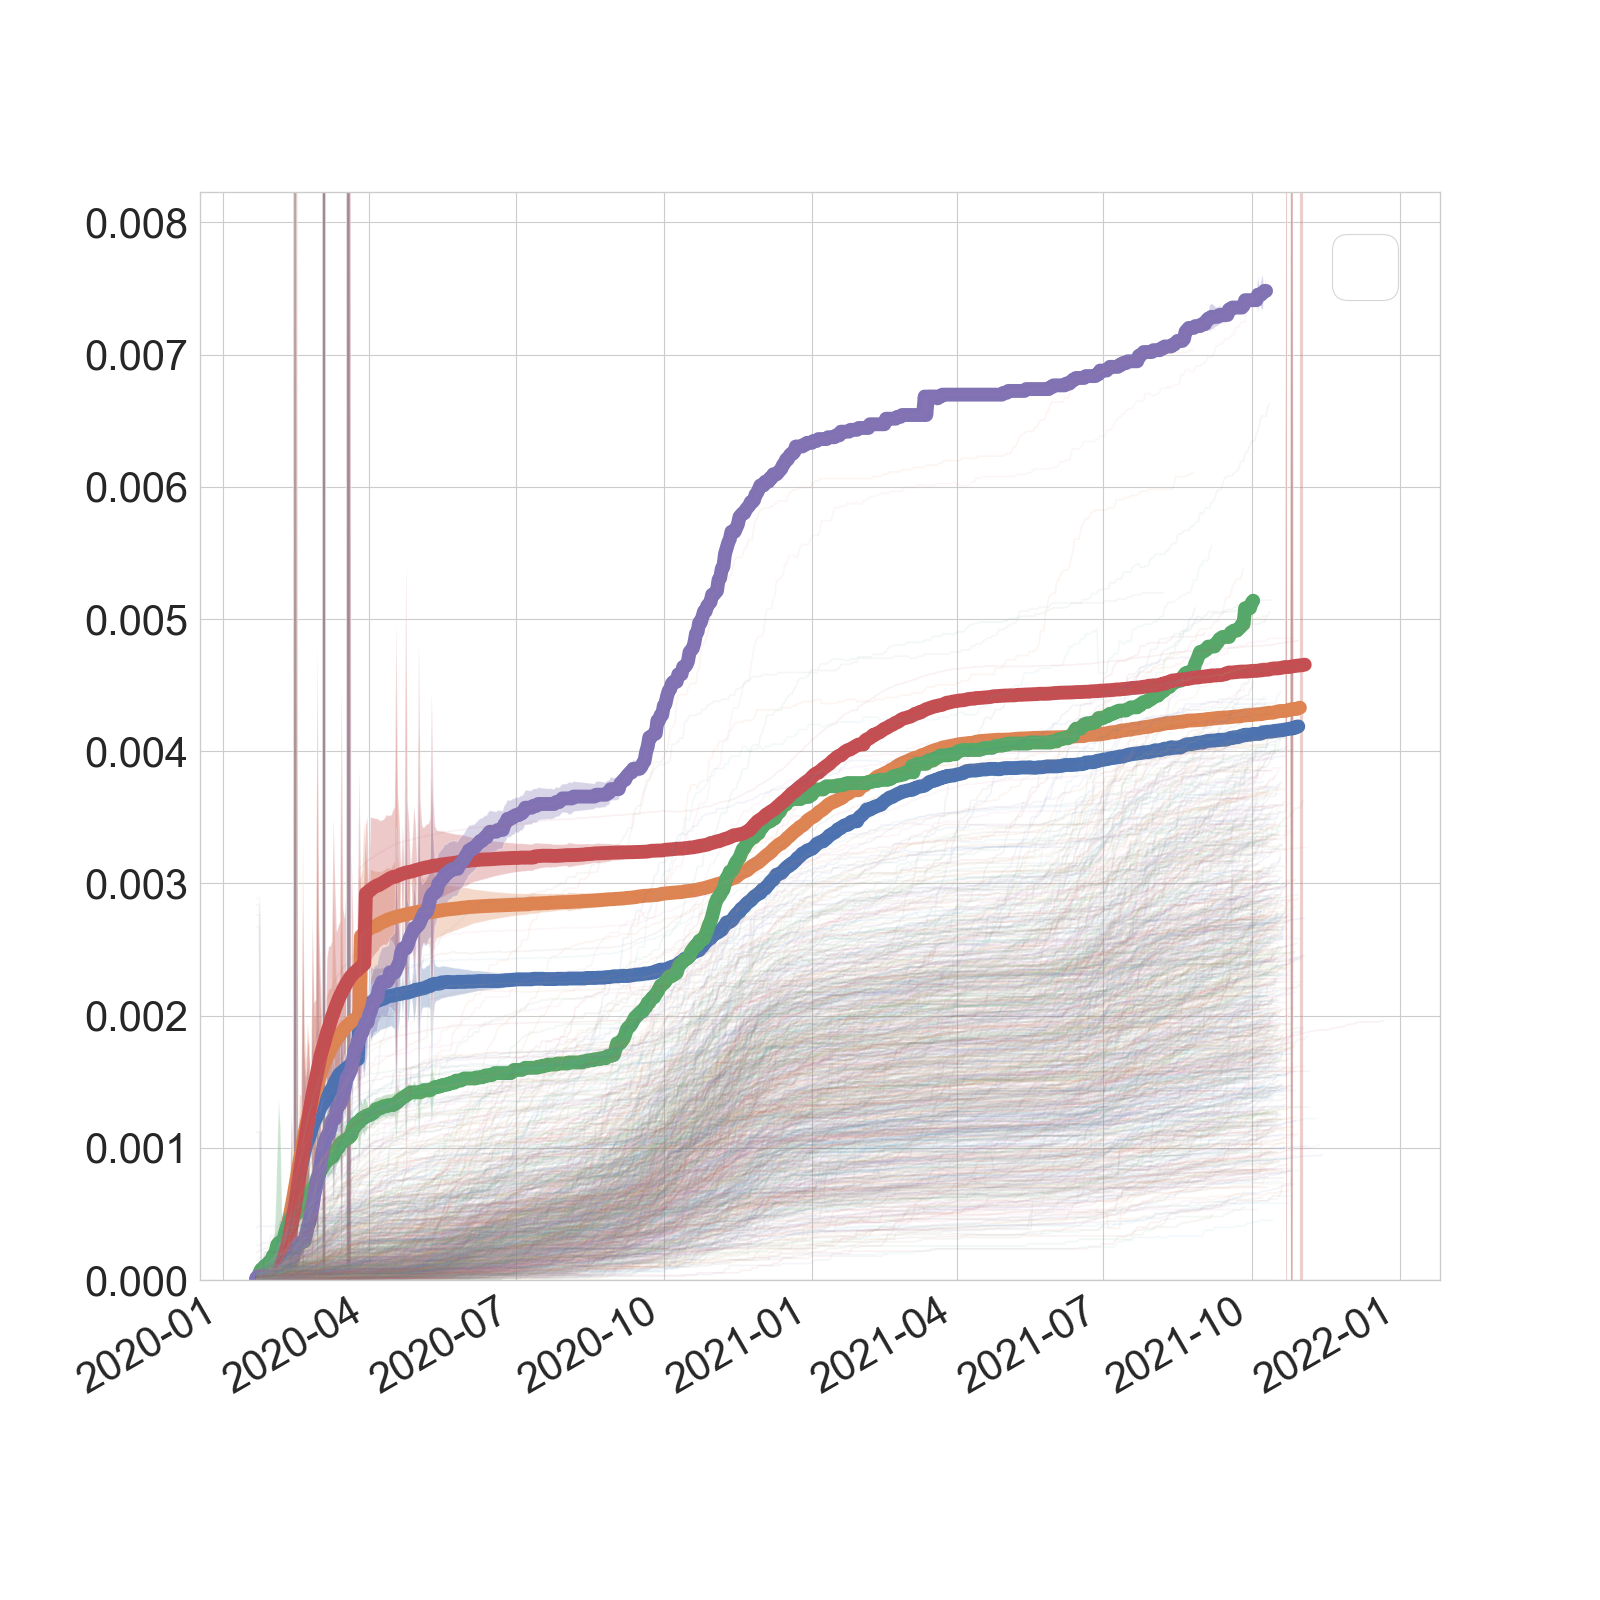

In [279]:
z=output['z']
ana_prob_array_0=np.copy(output['ana_prob_array'])
ana_prob_array=np.copy(ana_prob_array_0)
N,D=ana_prob_array_0.shape

z_full=np.ones((N,D))
for d in z.keys():
    z_full[:,d]=z[d]
z_full[z_full==1]=0
z_full*=-1

sorted_counties=np.argsort(-np.nanmean(z_full,axis=1))
ana_ts=sorted_counties[:5]
normal_ts=sorted_counties[:]

X_f=np.copy(np.array(deaths))


fig, (ax3) = plt.subplots(1, 1)
X_f[np.isnan(X_f)]=0
inds=sorted_counties[:5]
#     factor=1
factor=np.mean(X_f[inds])/np.max(ana_prob_array_0[inds])

ymax=np.max(np.max(deaths))
ax3.set_ylim([0,ymax*1.1])    

for i in inds:
        x,y=dates,np.array(deaths.iloc[i])
        
        probs=np.copy(ana_prob_array_0[i,:])

        y_upper, y_lower=y+probs*factor,y-probs*factor
        y_lower[y_lower<0]=0
        # label_str=data_deaths1[['Admin2']].iloc[i][0]+", "+data_deaths1[['Province_State']].iloc[i][0]
        
        ax3.plot(dates, y, linewidth=10)
        ax3.fill_between(dates, y_lower, y_upper,
                            alpha=0.3
                        )

ax3.legend(ncol=5,prop={'size': 60})
pd.DataFrame(deaths).T.set_index(dates).plot(alpha=0.075,legend=None, ax=ax3)
# ax3.set_ylabel(ylabel)
# plt.savefig(image_path+prefix+'_top_10_per_capita.png')
# plt.close('all')
